In [1]:
# Plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mne import concatenate_epochs
import numpy as np
import mne
from scipy.stats import f_oneway, ttest_rel
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection, multipletests
mne.set_log_level('warning')

In [2]:
df_1009 = pd.read_csv("results\\classification_results_single_cond_1009_first.csv")
df_1029 = pd.read_csv("results\\classification_results_single_cond_1029.csv")
print(df_1009['SVM_F0.5_Score'].mean(), df_1009['SVM_Accuracy'].mean())
print(df_1029['SVM_F0.5_Score'].mean(), df_1029['SVM_Accuracy'].mean())

0.759491523600765 0.26337142857142853
0.7778222794084257 0.3113333333333333


In [3]:
df_1009 = pd.read_csv("results\\cross_condition_results_first_1009.csv")
df_1029 = pd.read_csv("results\\cross_condition_results_1029.csv")
print(df_1009['SVM_F0.5'].mean(), df_1009['SVM_Accuracy'].mean())
print(df_1029['SVM_F0.5'].mean(), df_1029['SVM_Accuracy'].mean())

0.32178535075958165 0.2043574186431329
0.3825184485337133 0.24119662089586902


## Some Statistics

In [15]:
marker = 1009
conditions = ['Joystick', 'Leaning', 'Omnideck', 'Walking']
n_participants = 14
channels_of_interest = ['F3', 'Fz', 'F4', 'FC1', 'FCz', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2']

# Create structure to hold trial-level peak and baseline values
peak_neg_all = [{cond: [] for cond in conditions} for _ in range(n_participants)]
baseline_all = [{cond: [] for cond in conditions} for _ in range(n_participants)]

for cond in conditions:
    for p in range(1, n_participants + 1):
        if p in [4] or (p == 3 and cond == 'Omnideck') or (p == 7 and (cond == 'Joystick' or cond == 'Leaning')) or (p == 13 and cond == 'Walking') :
            # Missing data case — append np.nan to indicate this condition is absent
            peak_neg_all[p-1][cond] = np.nan
            baseline_all[p-1][cond] = np.nan
            continue

        path = f'epochs\\P{p:03d}\\'
        all_epochs = []

        for i in range(1, 3):  # Assume 2 sessions per condition
            if marker == 1009:
                filename = f'sub-P{p:03d}_ses-{cond}{i}_epochs_first_{marker}_autoreject_epo.fif'
            else:
                filename = f'sub-P{p:03d}_ses-{cond}{i}_epochs_{marker}_autoreject_epo.fif'
            epochs = mne.read_epochs(path + filename, preload=True)
            all_epochs.append(epochs)

        epochs = concatenate_epochs(all_epochs, verbose=False)
        epochs = epochs.pick(channels_of_interest)

        # Apply autoreject
        #ar = AutoReject(n_jobs=8, verbose=False)
        #epochs = ar.fit_transform(epochs)

        # Crop for MRCP and baseline windows
        if marker == 1009:
            epochs_mrcp = epochs.copy().crop(tmin=-1.5, tmax=0)
            epochs_base = epochs.copy().crop(tmin=-6, tmax=-2)
        else:
            epochs_mrcp = epochs.copy().crop(tmin=-0.5, tmax=1)
            epochs_base = epochs.copy().crop(tmin=-5, tmax=-1)

        # Extract data (trials x channels x timepoints)
        mrcp_data = epochs_mrcp.get_data()  # shape: (n_trials, n_channels, n_times)
        base_data = epochs_base.get_data()

        # Peak negativity: min across time for each trial and channel
        peak_neg = np.min(mrcp_data, axis=2)  # shape: (n_trials, n_channels)
        baseline_mean = np.mean(base_data, axis=2)  # shape: (n_trials, n_channels)

        peak_neg_all[p-1][cond] = peak_neg  # shape: trials × channels
        baseline_all[p-1][cond] = baseline_mean


C:\Users\stadl\AppData\Local\Temp\ipykernel_7700\3811616591.py:29: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = concatenate_epochs(all_epochs, verbose=False)
C:\Users\stadl\AppData\Local\Temp\ipykernel_7700\3811616591.py:29: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = concatenate_epochs(all_epochs, verbose=False)
C:\Users\stadl\AppData\Local\Temp\ipykernel_7700\3811616591.py:29: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = concatenate_epochs(all_epochs, verbose=False)
C:\Users\stadl\AppData\Local\Temp\ipykernel_7700\3811616591.py:29: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = concatenate_epochs(all_epochs, verbose=False)
C:\Users\stadl\AppData\Local\Temp\ipykernel_7700

In [16]:
pvals = np.full((n_participants, len(conditions), len(channels_of_interest)), np.nan)
significant = np.zeros_like(pvals, dtype=bool)

# Paired t-tests Between the mean of baseline and peak negativity
for p in range(n_participants):
    for c_idx, cond in enumerate(conditions):
        peak = peak_neg_all[p][cond]
        base = baseline_all[p][cond]

        if isinstance(peak, float) and np.isnan(peak):
            continue  # Skip missing data

        for ch_idx in range(len(channels_of_interest)):
            # trial-level comparison
            t_stat, p_val = ttest_rel(base[:, ch_idx], peak[:, ch_idx])
            pvals[p, c_idx, ch_idx] = p_val
            significant[p, c_idx, ch_idx] = p_val < 0.05

# Correction for Mulitple comparisons
# Flatten across channels for correction
for p in range(n_participants):
    for c_idx, cond in enumerate(conditions):
        raw_pvals = pvals[p, c_idx, :]
        if np.isnan(raw_pvals).all():
            continue
        reject, corrected_pvals, _, _ = multipletests(raw_pvals, alpha=0.05, method='bonferroni')
        pvals[p, c_idx, :] = corrected_pvals
        significant[p, c_idx, :] = reject


data = []
for p_idx, p_data in enumerate(peak_neg_all):
    if p_idx == 6:  # Skip participant 7 (0-indexed)
        continue
    for cond, arr in p_data.items():
        if isinstance(arr, float) or arr is np.nan:
            continue
        for trial in arr:  # shape: (n_channels,)
            avg_peak_neg = np.mean(trial)  # average across channels
            data.append({
                'Participant': f'P{p_idx + 1}',
                'PeakNeg': avg_peak_neg,
                'Condition': cond
            })
# P, avg across channel peak negativity, cond (max number of entries is 152 for 1009 and 1029 per subject; 19x2x4)
df = pd.DataFrame(data)

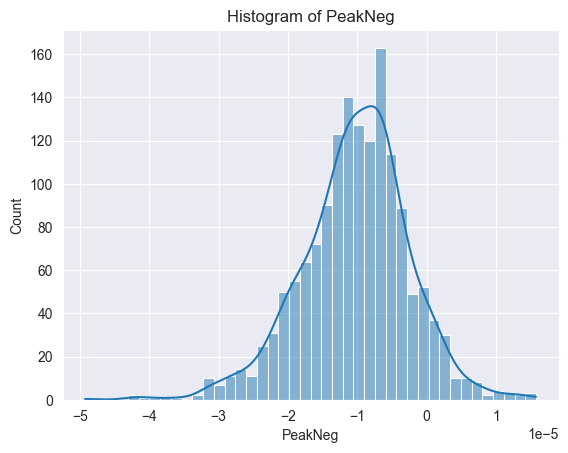

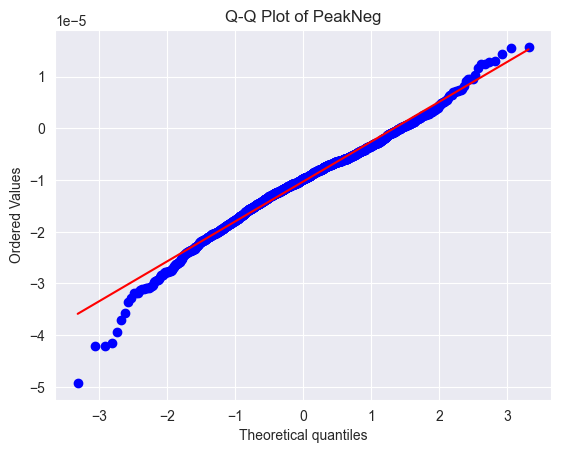

In [17]:
# Checking for normality
sns.histplot(df['PeakNeg'], kde=True)
plt.title('Histogram of PeakNeg')
plt.show()


stats.probplot(df['PeakNeg'], dist="norm", plot=plt)
plt.title('Q-Q Plot of PeakNeg')
plt.show()

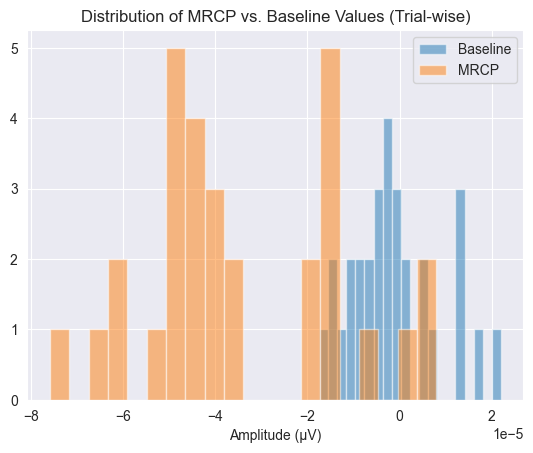

In [18]:
participant = 0
cond = 'Leaning'
ch_idx = channels_of_interest.index('FCz')

peak = peak_neg_all[participant][cond][:, ch_idx]
base = baseline_all[participant][cond][:, ch_idx]

plt.hist(base, bins=20, alpha=0.5, label='Baseline')
plt.hist(peak, bins=20, alpha=0.5, label='MRCP')
plt.title("Distribution of MRCP vs. Baseline Values (Trial-wise)")
plt.xlabel("Amplitude (µV)")
plt.legend()
plt.show()

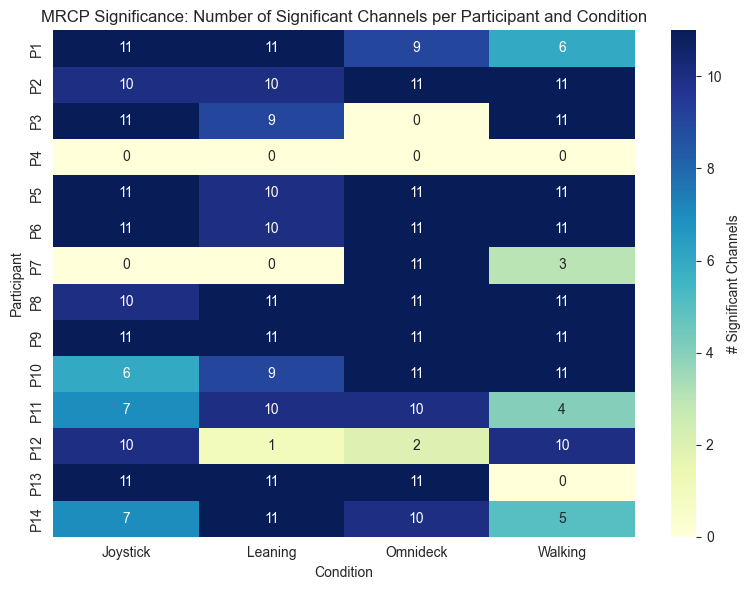

<Figure size 640x480 with 0 Axes>

In [19]:
# Step 1: Summarize the number of significant channels per participant per condition
# shape: (14 participants, 4 conditions)
sig_counts = significant.sum(axis=2)

# Step 2: Convert to a DataFrame for easy labeling
participant_labels = [f"P{p+1}" for p in range(14)]
condition_labels = ['Joystick', 'Leaning', 'Omnideck', 'Walking']

df_ = pd.DataFrame(sig_counts, index=participant_labels, columns=condition_labels)

# Step 3: Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': '# Significant Channels'})
plt.title("MRCP Significance: Number of Significant Channels per Participant and Condition")
plt.xlabel("Condition")
plt.ylabel("Participant")
plt.tight_layout()
plt.show()
plt.savefig(f'{marker}_significant_count.png')


In [20]:
df

,Participant,PeakNeg,Condition
0,P1,-0.000011,Joystick
1,P1,-0.000008,Joystick
2,P1,-0.000004,Joystick
3,P1,-0.000006,Joystick
4,P1,-0.000012,Joystick
...,...,...,...
1530,P14,-0.000006,Walking
1531,P14,-0.000015,Walking
1532,P14,-0.000010,Walking
1533,P14,-0.000010,Walking


In [21]:
# Group by participant ANOVA
groups = [g['PeakNeg'].values for _, g in df.groupby('Participant')]

f_stat, p_val = f_oneway(*groups)
print(f"F = {f_stat}, p = {p_val}")


k = len(groups)
# Total number of data points
N = sum(len(g) for g in groups)

# Degrees of freedom
df_between = k - 1
df_within = N - k
print(df_between, df_within)

F = 8.610805192203177, p = 6.283371594667204e-15
11 1523


(134,)

In [11]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(
    endog=df['PeakNeg'],             # dependent variable
    groups=df['Participant'],        # group labels
    alpha=0.05                       # significance level
)

print(tukey)
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
participants = df['Participant'].unique()

differs_from_all = []

for participant in participants:
    # Get all pairwise comparisons involving this participant
    matches = tukey_df[(tukey_df['group1'] == participant) | (tukey_df['group2'] == participant)]

    # Check if ALL comparisons were significant (reject == True)
    if matches['reject'].all():
        differs_from_all.append(participant)

print("Participants that differ significantly from ALL others:")
print(differs_from_all)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower upper reject
------------------------------------------------
    P1    P10     -0.0 0.0024  -0.0  -0.0   True
    P1    P11     -0.0 0.0253  -0.0  -0.0   True
    P1    P12     -0.0 0.0028  -0.0  -0.0   True
    P1    P13      0.0 0.9989  -0.0   0.0  False
    P1    P14     -0.0    0.0  -0.0  -0.0   True
    P1     P2     -0.0 0.7371  -0.0   0.0  False
    P1     P3     -0.0  0.995  -0.0   0.0  False
    P1     P5     -0.0 0.0638  -0.0   0.0  False
    P1     P6     -0.0 0.9927  -0.0   0.0  False
    P1     P8     -0.0    0.0  -0.0  -0.0   True
    P1     P9     -0.0    0.0  -0.0  -0.0   True
   P10    P11      0.0    1.0  -0.0   0.0  False
   P10    P12     -0.0    1.0  -0.0   0.0  False
   P10    P13      0.0 0.0001   0.0   0.0   True
   P10    P14     -0.0  0.006  -0.0  -0.0   True
   P10     P2      0.0 0.4997  -0.0   0.0  False
   P10     P3      0.0 0.1547  -0.0   0.0  False
   P10     P5    

## Difference of MRCP across condition

In [25]:
data = []

for p in range(n_participants):
    if p in [2, 6, 12]:
        continue
    for c_idx, cond in enumerate(conditions):
        peak = peak_neg_all[p][cond]
        if isinstance(peak, float) or peak is None:
            continue  # Skip missing
        # Example: average across trials and selected channels (e.g., Cz, FCz)
        ch_idxs = [channels_of_interest.index(ch) for ch in ['F3', 'Fz', 'F4', 'FC1', 'FCz', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2']]
        mean_peak = np.min(peak[:, ch_idxs])
        data.append({
            'participant': p,
            'condition': cond,
            'mean_mrcp': mean_peak
        })

df = pd.DataFrame(data)
#df = df.drop([6, 12], axis=0).reset_index(drop=True)
df

,participant,condition,mean_mrcp
0,0,Joystick,-0.000052
1,0,Leaning,-0.000106
2,0,Omnideck,-0.000046
3,0,Walking,-0.000041
4,1,Joystick,-0.000035
5,1,Leaning,-0.000048
6,1,Omnideck,-0.000043
7,1,Walking,-0.000049
8,4,Joystick,-0.000049
9,4,Leaning,-0.000043


In [26]:
print(df.pivot(index='participant', columns='condition', values='mean_mrcp'))

condition    Joystick   Leaning  Omnideck   Walking
participant                                        
0           -0.000052 -0.000106 -0.000046 -0.000041
1           -0.000035 -0.000048 -0.000043 -0.000049
4           -0.000049 -0.000043 -0.000031 -0.000034
5           -0.000048 -0.000052 -0.000054 -0.000063
7           -0.000064 -0.000062 -0.000048 -0.000071
8           -0.000058 -0.000042 -0.000052 -0.000078
9           -0.000079 -0.000077 -0.000047 -0.000079
10          -0.000070 -0.000077 -0.000085 -0.000058
11          -0.000066 -0.000183 -0.000051 -0.000070
13          -0.000133 -0.000048 -0.000081 -0.000140


In [27]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

anova = AnovaRM(df, depvar='mean_mrcp', subject='participant', within=['condition'])
res = anova.fit()
print(res)

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
condition  0.9829 3.0000 27.0000 0.4155



In [28]:
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

conditions = df['condition'].unique()
pairs = [(a, b) for i, a in enumerate(conditions) for b in conditions[i+1:]]

pvals = []
for a, b in pairs:
    a_vals = df[df['condition'] == a].sort_values('participant')['mean_mrcp']
    b_vals = df[df['condition'] == b].sort_values('participant')['mean_mrcp']
    stat, p = ttest_rel(a_vals, b_vals)
    pvals.append(p)

# Correct for multiple comparisons
rejected, pvals_corrected, _, _ = multipletests(pvals, method='bonferroni')

# Print results
for (a, b), p_corr, sig in zip(pairs, pvals_corrected, rejected):
    print(f"{a} vs {b}: p={p_corr:.4f} {'*' if sig else ''}")

Joystick vs Leaning: p=1.0000 
Joystick vs Omnideck: p=0.5968 
Joystick vs Walking: p=1.0000 
Leaning vs Omnideck: p=1.0000 
Leaning vs Walking: p=1.0000 
Omnideck vs Walking: p=0.4470 


## In condition testing results

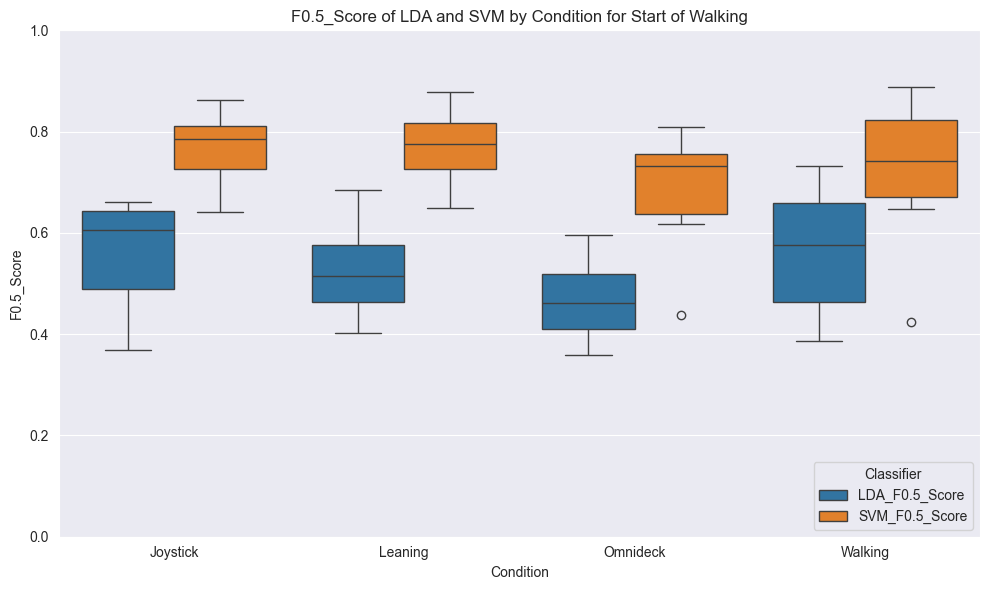

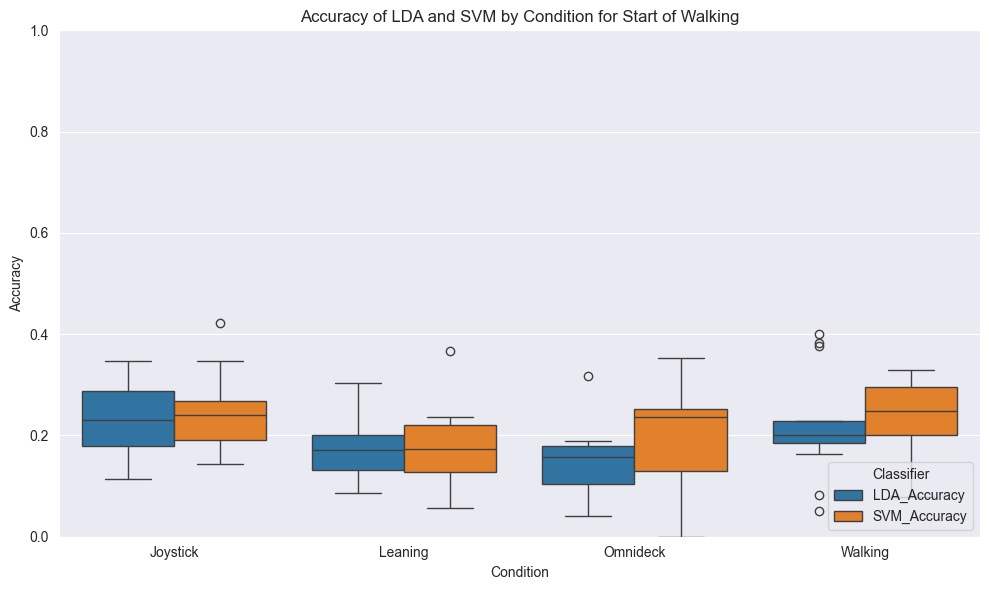

In [6]:
# Load the CSV file
df = pd.read_csv("results\\classification_results_single_cond_1029.csv")
measures = ['F0.5_Score', 'Accuracy']
# Assuming your dataframe has columns named: 'Participant', 'condition', 'LDA_accuracy', 'SVM_accuracy'
# Melt the dataframe to long format for seaborn boxplot
for measure in measures:
    df_melted = pd.melt(
        df,
        id_vars=['Participant', 'Condition'],
        value_vars=[f'LDA_{measure}', f'SVM_{measure}'],
        var_name='Classifier',
        value_name=measure
    )

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Condition', y=measure, hue='Classifier', data=df_melted)
    # Add some plot formatting
    plt.title(f'{measure} of LDA and SVM by Condition for Start of Walking')
    plt.xlabel('Condition')
    plt.ylim(0, 1)
    plt.ylabel(measure)
    plt.legend(title='Classifier', loc='lower right')
    plt.tight_layout()
    plt.savefig(f'results\\{measure}_by_cond_1029.png')
    plt.show()



In [12]:
df = pd.read_csv("results\\classification_results_single_cond_1029.csv")
lda_df = df.pivot(index='Participant', columns='Condition', values='LDA_F0.5_Score')

# SVM pivoted scores
svm_df = df.pivot(index='Participant', columns='Condition', values='SVM_Accuracy')
svm_df

Condition,Joystick,Leaning,Omnideck,Walking
Participant,,,,
1,0.142857,0.200000,0.085714,0.214286
2,0.271429,0.114286,0.130000,0.250000
3,0.246429,0.171429,0.050000,0.260714
4,NaN,NaN,NaN,NaN
5,0.164286,0.235714,0.239286,0.078571
6,0.266667,0.057143,0.000000,0.313333
7,NaN,NaN,0.314286,0.219048
8,0.239286,0.221429,0.220000,0.106667
9,0.142857,0.066667,0.250000,0.139286


C:\Users\stadl\AppData\Local\Temp\ipykernel_9768\2091122804.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Participant', y='SVM_Accuracy', data=df_cond, palette='crest')


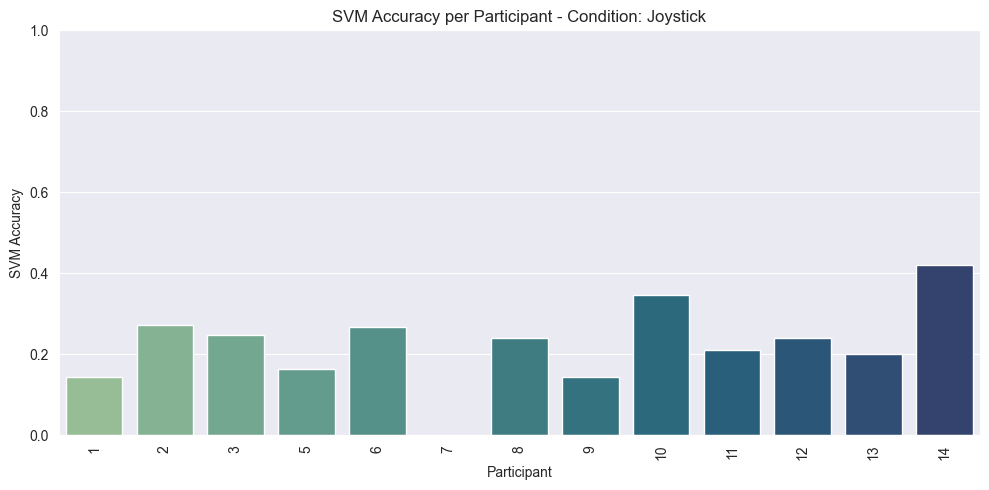

C:\Users\stadl\AppData\Local\Temp\ipykernel_9768\2091122804.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Participant', y='SVM_Accuracy', data=df_cond, palette='crest')


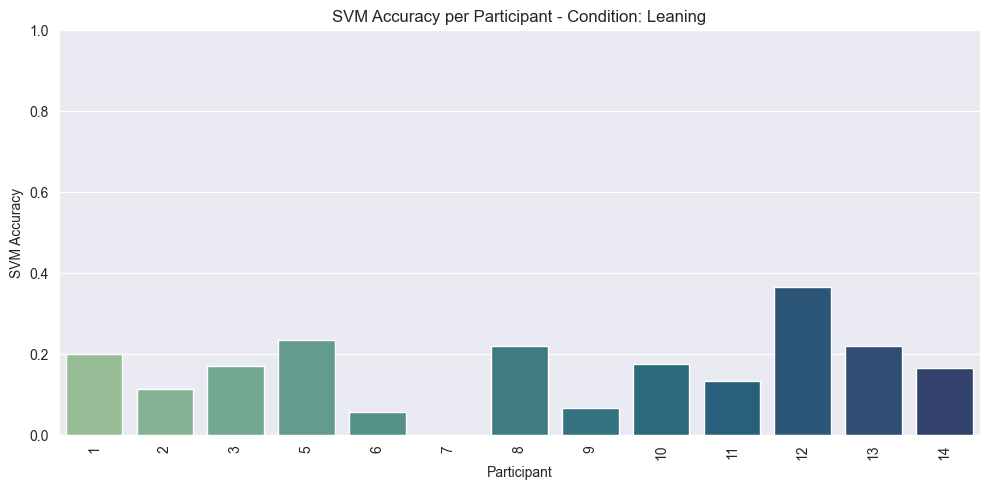

C:\Users\stadl\AppData\Local\Temp\ipykernel_9768\2091122804.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Participant', y='SVM_Accuracy', data=df_cond, palette='crest')


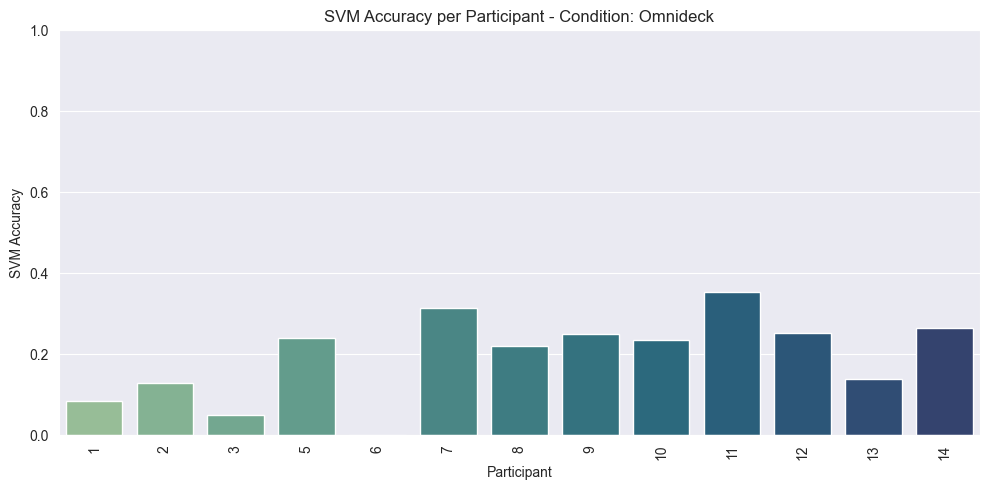

C:\Users\stadl\AppData\Local\Temp\ipykernel_9768\2091122804.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Participant', y='SVM_Accuracy', data=df_cond, palette='crest')


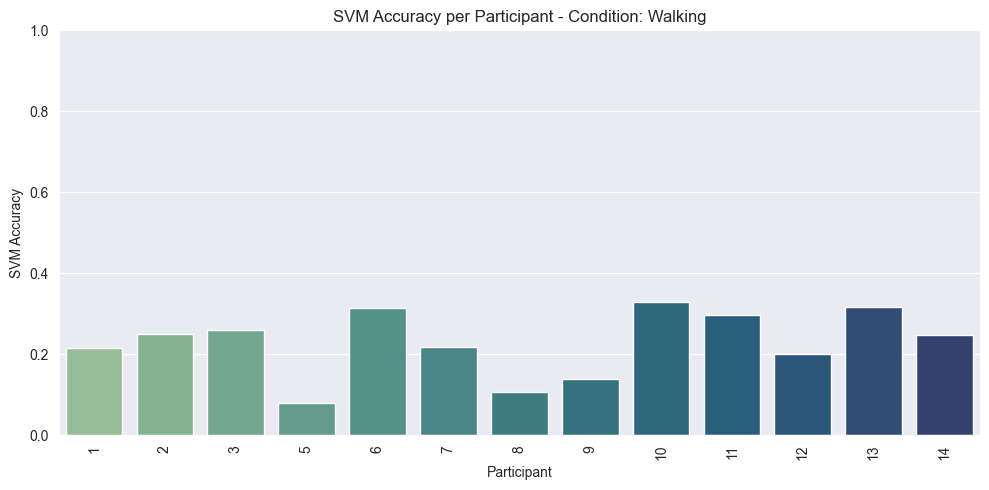

In [11]:
# Load data
df = pd.read_csv("results\\classification_results_single_cond_1029.csv")
df = df[df['Participant'] != 4]
# Get unique conditions
conditions = df['Condition'].unique()

# Loop and plot per condition
for cond in conditions:
    df_cond = df[df['Condition'] == cond].sort_values(by='SVM_Accuracy', ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(x='Participant', y='SVM_Accuracy', data=df_cond, palette='crest')

    plt.title(f'SVM Accuracy per Participant - Condition: {cond}')
    plt.xlabel('Participant')
    plt.ylabel('SVM Accuracy')
    plt.xticks(rotation=90)
    plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
    plt.tight_layout()
    plt.show()

C:\Users\stadl\AppData\Local\Temp\ipykernel_9768\401613534.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Participant', y='LDA_Accuracy', data=df_avg, palette='viridis')


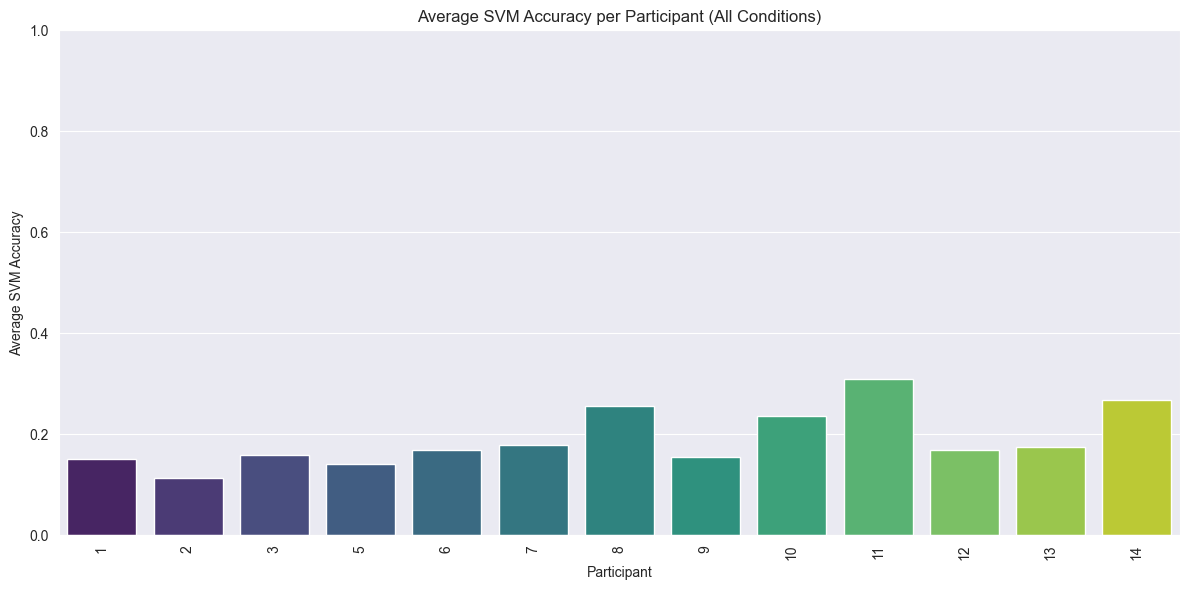

In [9]:
df_avg = df.groupby('Participant')['LDA_Accuracy'].mean().reset_index()

# Sort by average accuracy
df_avg = df_avg.sort_values(by='LDA_Accuracy', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Participant', y='LDA_Accuracy', data=df_avg, palette='viridis')

plt.title('Average SVM Accuracy per Participant (All Conditions)')
plt.xlabel('Participant')
plt.ylabel('Average SVM Accuracy')
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [10]:
# Group by Condition and aggregate
agg_stats = df.groupby('Condition').agg(['mean', 'median', 'std'])

# Optional: Clean up column names if needed
agg_stats.columns = ['_'.join(col).strip() for col in agg_stats.columns.values]

# Display the result
print(agg_stats)

           Participant_mean  Participant_median  Participant_std  \
Condition                                                          
Joystick           7.769231                 8.0         4.225988   
Leaning            7.769231                 8.0         4.225988   
Omnideck           7.769231                 8.0         4.225988   
Walking            7.769231                 8.0         4.225988   

           LDA_F0.5_Score_mean  LDA_F0.5_Score_median  LDA_F0.5_Score_std  \
Condition                                                                   
Joystick              0.566135               0.606218            0.094868   
Leaning               0.522652               0.514100            0.087957   
Omnideck              0.467860               0.460832            0.077896   
Walking               0.561190               0.576569            0.110676   

           SVM_F0.5_Score_mean  SVM_F0.5_Score_median  SVM_F0.5_Score_std  \
Condition                                          

Some Results based statistics

In [ ]:
results = []

for condition in df['Condition'].unique():
    subset = df[df['Condition'] == condition]

    # Drop rows with NaNs in either LDA or SVM scores
    scores = subset[['LDA_Accuracy', 'SVM_Accuracy']].dropna()

    lda_scores = scores['LDA_Accuracy']
    svm_scores = scores['SVM_Accuracy']

    # Check if enough data remains
    if len(scores) < 2:
        results.append({
            'Condition': condition,
            'T-test p-value': None,
            'Wilcoxon p-value': None,
            'LDA mean': lda_scores.median() if not lda_scores.empty else None,
            'SVM mean': svm_scores.median() if not svm_scores.empty else None,
            'Note': 'Not enough data'
        })
        continue

    # Paired t-test
    t_stat, p_ttest = ttest_rel(lda_scores, svm_scores)

    # Wilcoxon test (with error handling)
    try:
        w_stat, p_wilcoxon = wilcoxon(lda_scores, svm_scores)
    except ValueError:
        p_wilcoxon = None

    results.append({
        'Condition': condition,
        'T-test p-value': p_ttest,
        'Wilcoxon p-value': p_wilcoxon,
        'LDA mean': lda_scores.median(),
        'SVM mean': svm_scores.median(),
        'Note': None
    })

stats_df = pd.DataFrame(results)
print(stats_df)

## Transfer Learning Results


In [12]:
df = pd.read_csv("results\\cross_condition_results_first_1009.csv")
df_joystick_mean = np.nanmean(df[df['Test_Condition'] == 'Joystick']['SVM_Accuracy'])
df_leaning_mean = np.nanmean(df[df['Test_Condition'] == 'Leaning']['SVM_Accuracy'])
df_omnideck_mean = np.nanmean(df[df['Test_Condition'] == 'Omnideck']['SVM_Accuracy'])
df_walking_mean = np.nanmean(df[df['Test_Condition'] == 'Walking']['SVM_Accuracy'])
print(np.mean([df_joystick_mean, df_leaning_mean, df_omnideck_mean, df_walking_mean]))

0.22875290012939972


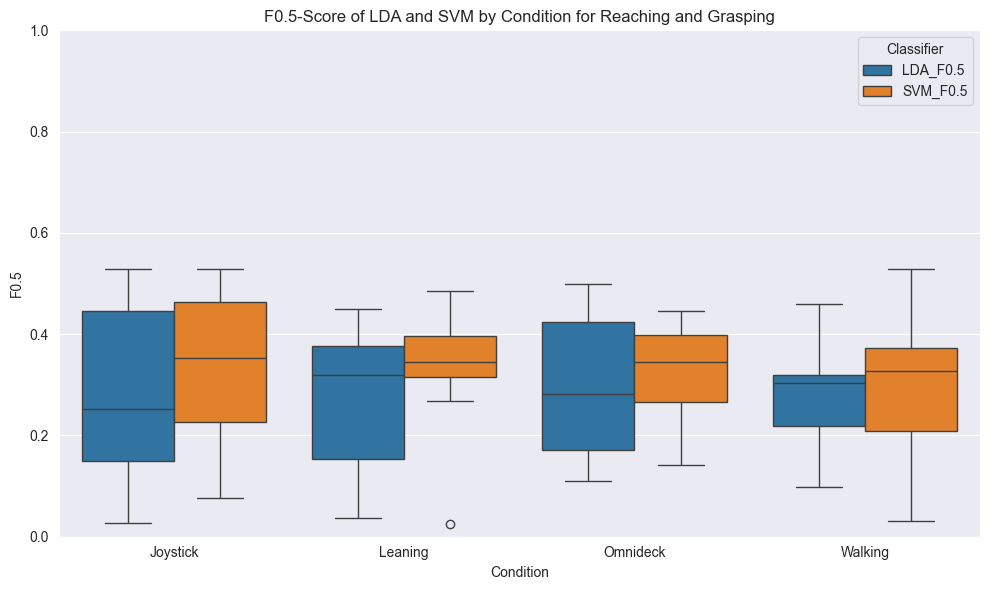

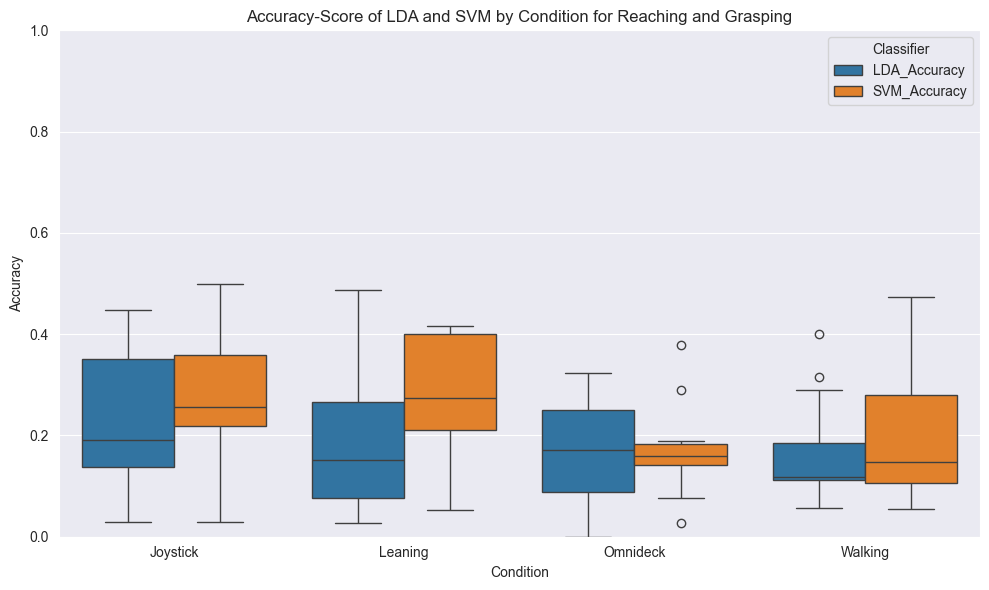

In [39]:
df_transfer = pd.read_csv("results\\cross_condition_results_first_1009.csv")
measures = ['F0.5', 'Accuracy']
# Assuming your dataframe has columns named: 'Participant', 'condition', 'LDA_accuracy', 'SVM_accuracy'
# Melt the dataframe to long format for seaborn boxplot
for measure in measures:
    df_melted = pd.melt(
        df_transfer,
        id_vars=['Participant', 'Test_Condition'],
        value_vars=[f'LDA_{measure}', f'SVM_{measure}'],
        var_name='Classifier',
        value_name=measure
    )

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Test_Condition', y=measure, hue='Classifier', data=df_melted)
    # Add some plot formatting
    plt.title(f'{measure}-Score of LDA and SVM by Condition for Reaching and Grasping')
    plt.xlabel('Condition')
    plt.ylim(0, 1)
    plt.ylabel(measure)
    plt.legend(title='Classifier', loc='upper right')
    plt.tight_layout()
    plt.savefig(f'results\\{measure}_leave_one_out_first_1009.png')
    plt.show()


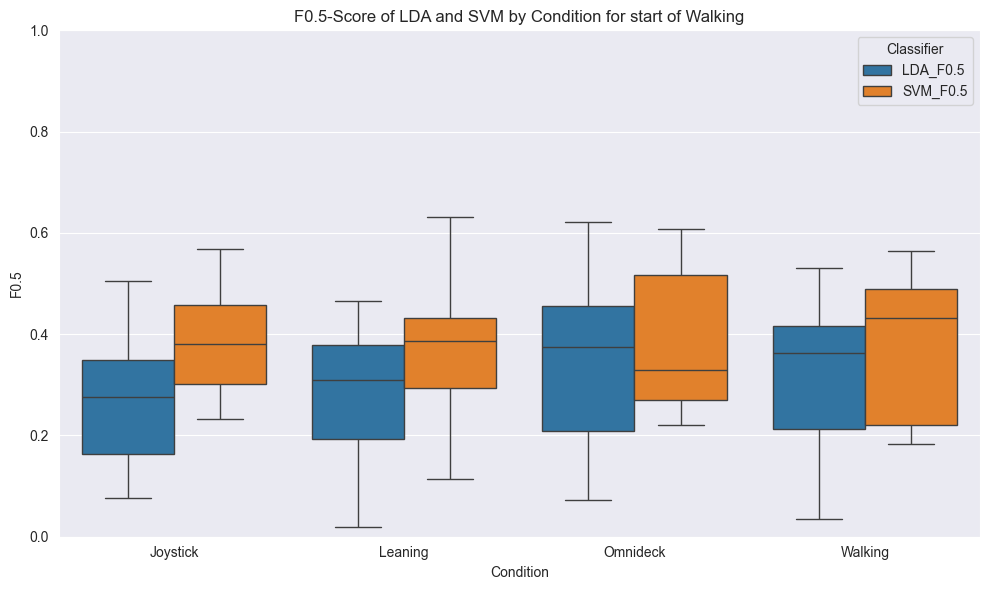

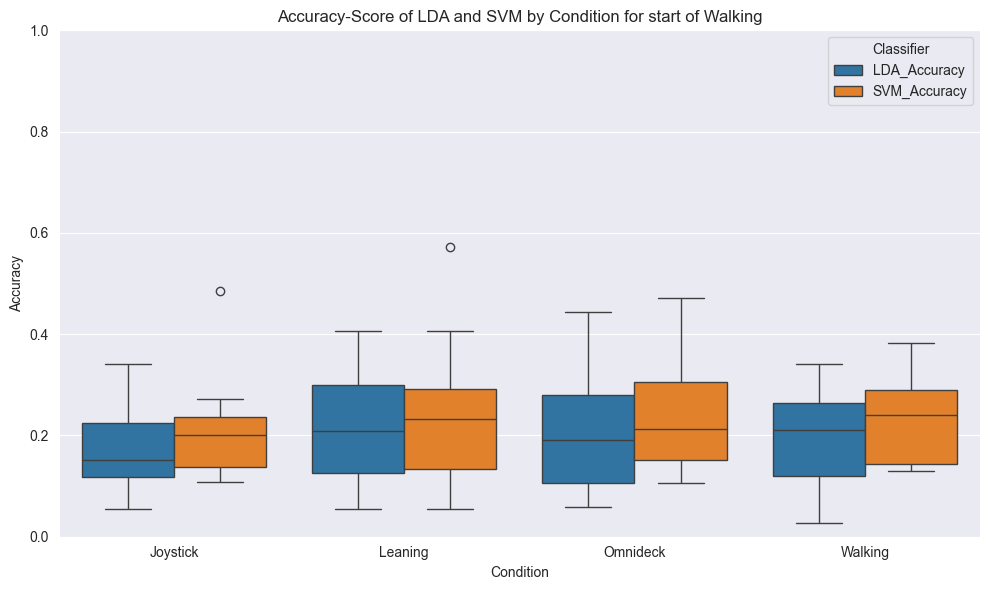

In [13]:
df_transfer = pd.read_csv("results\\cross_condition_results_1029.csv")
measures = ['F0.5', 'Accuracy']
# Assuming your dataframe has columns named: 'Participant', 'condition', 'LDA_accuracy', 'SVM_accuracy'
# Melt the dataframe to long format for seaborn boxplot
for measure in measures:
    df_melted = pd.melt(
        df_transfer,
        id_vars=['Participant', 'Test_Condition'],
        value_vars=[f'LDA_{measure}', f'SVM_{measure}'],
        var_name='Classifier',
        value_name=measure
    )

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Test_Condition', y=measure, hue='Classifier', data=df_melted)
    # Add some plot formatting
    plt.title(f'{measure}-Score of LDA and SVM by Condition for start of Walking')
    plt.xlabel('Condition')
    plt.ylim(0, 1)
    plt.ylabel(measure)
    plt.legend(title='Classifier', loc='upper right')
    plt.tight_layout()
    plt.savefig(f'results\\{measure}_leave_one_out_1029.png')
    plt.show()


## Omnideck and Walking Trasfer

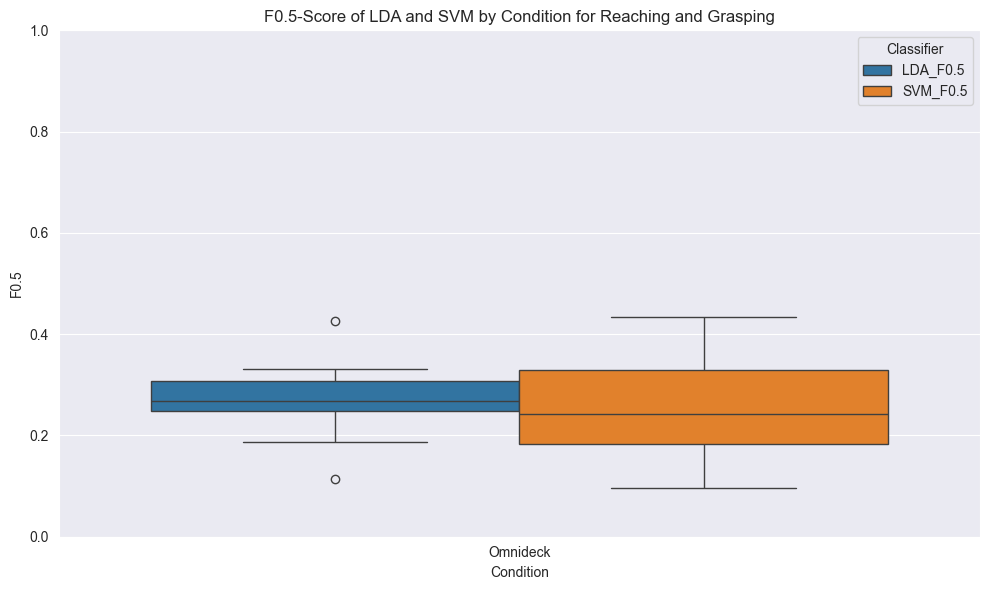

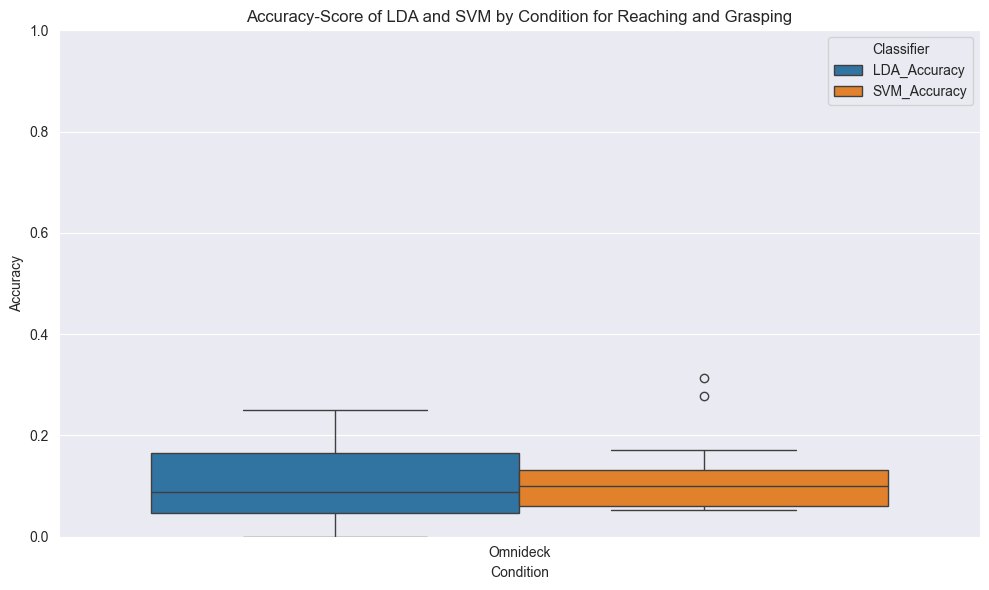

In [36]:
df_transfer = pd.read_csv("results\\transfer_learning_omideck_walking_first_1009_results.csv")
df_transfer_omnideck = df_transfer[df_transfer['Train_Condition']=='Omnideck']
df_transfer_walking = df_transfer[df_transfer['Train_Condition']=='Walking']
measures = ['F0.5', 'Accuracy']
# Assuming your dataframe has columns named: 'Participant', 'condition', 'LDA_accuracy', 'SVM_accuracy'
# Melt the dataframe to long format for seaborn boxplot
for measure in measures:
    df_melted = pd.melt(
        df_transfer_walking,
        id_vars=['Participant', 'Test_Condition'],
        value_vars=[f'LDA_{measure}', f'SVM_{measure}'],
        var_name='Classifier',
        value_name=measure
    )

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Test_Condition', y=measure, hue='Classifier', data=df_melted)
    # Add some plot formatting
    plt.title(f'{measure}-Score of LDA and SVM by Condition for Reaching and Grasping')
    plt.xlabel('Condition')
    plt.ylim(0, 1)
    plt.ylabel(measure)
    plt.legend(title='Classifier', loc='upper right')
    plt.tight_layout()
    plt.savefig(f'results\\{measure}_leave_one_out_first_1009.png')
    plt.show()

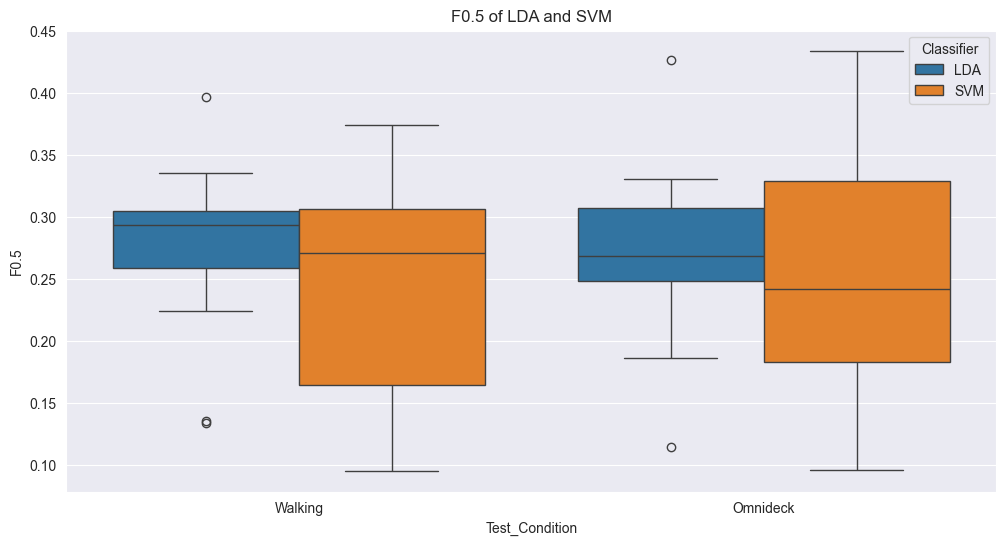

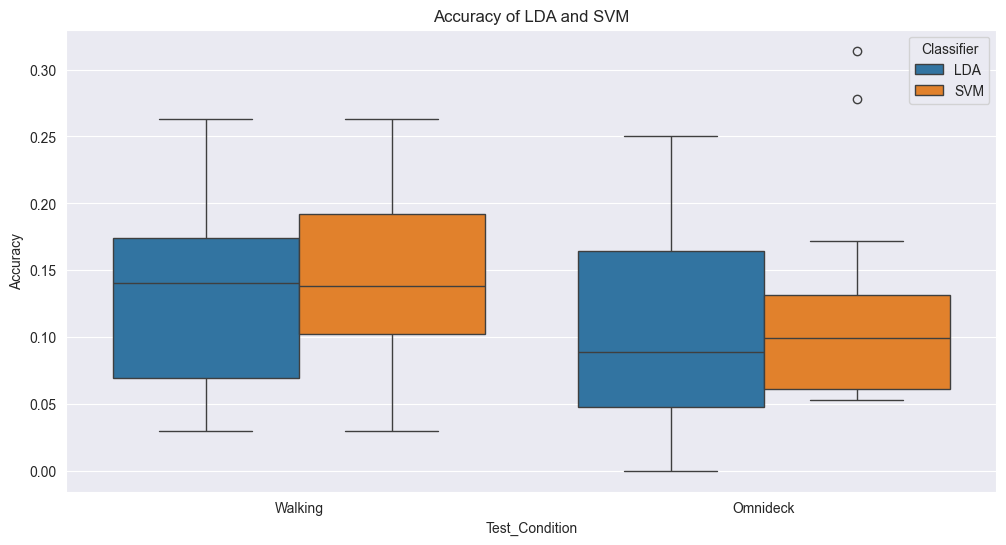

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df_transfer = pd.read_csv("results\\transfer_learning_omideck_walking_first_1009_results.csv")

# Split based on training condition
df_transfer_omnideck = df_transfer[df_transfer['Train_Condition'] == 'Omnideck'].copy()
df_transfer_walking = df_transfer[df_transfer['Train_Condition'] == 'Walking'].copy()

# Add a column to label the training condition
df_transfer_omnideck['Train_Condition_Label'] = 'Omnideck'
df_transfer_walking['Train_Condition_Label'] = 'Walking'

# Combine both
df_combined = pd.concat([df_transfer_omnideck, df_transfer_walking], ignore_index=True)

measures = ['F0.5', 'Accuracy']

for measure in measures:
    # Melt the combined dataframe
    df_melted = pd.melt(
        df_combined,
        id_vars=['Participant', 'Test_Condition', 'Train_Condition_Label'],
        value_vars=[f'LDA_{measure}', f'SVM_{measure}'],
        var_name='Classifier',
        value_name=measure
    )

    # Optional: clean classifier names
    df_melted['Classifier'] = df_melted['Classifier'].str.replace(f'_{measure}', '', regex=False)

    # Create the boxplot with separate columns for training conditions
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x='Test_Condition',
        y=measure,
        hue='Classifier',
        data=df_melted,
    )

    plt.title(f'{measure} of LDA and SVM')
    plt.savefig(f'results\\{measure}_walking-omnideck_transfer_1009.png')
    plt.show()


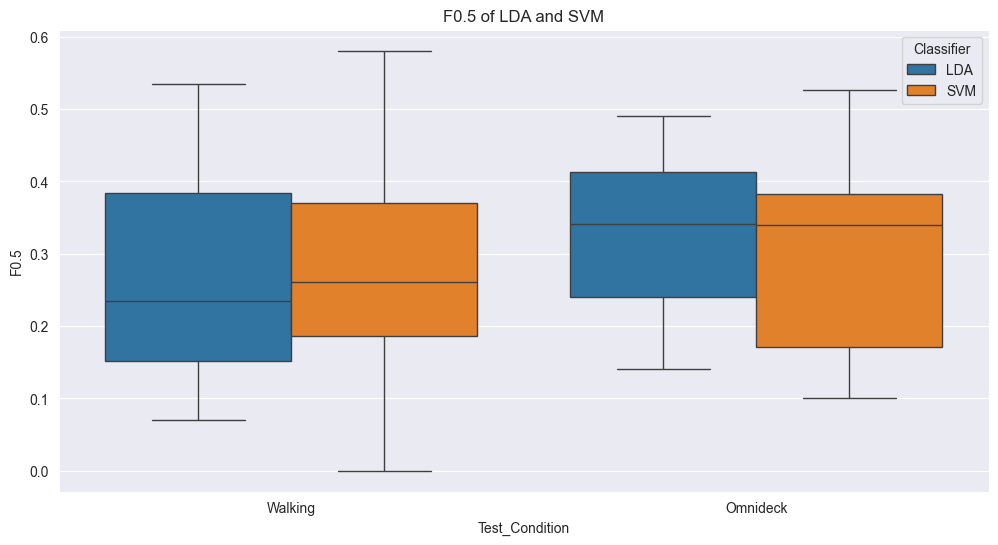

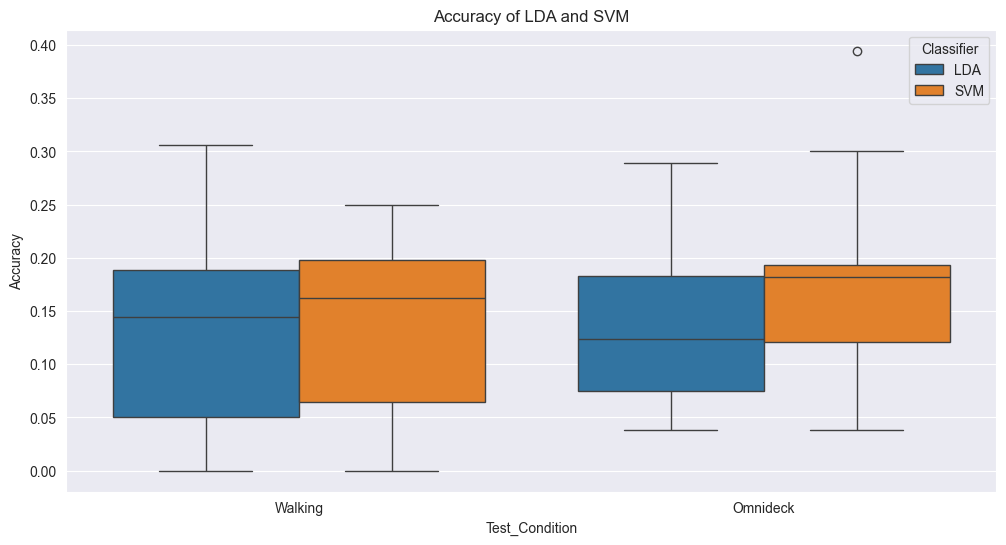

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df_transfer = pd.read_csv("results\\transfer_learning_omideck_walking_1029_results.csv")

# Split based on training condition
df_transfer_omnideck = df_transfer[df_transfer['Train_Condition'] == 'Omnideck'].copy()
df_transfer_walking = df_transfer[df_transfer['Train_Condition'] == 'Walking'].copy()

# Add a column to label the training condition
df_transfer_omnideck['Train_Condition_Label'] = 'Omnideck'
df_transfer_walking['Train_Condition_Label'] = 'Walking'

# Combine both
df_combined = pd.concat([df_transfer_omnideck, df_transfer_walking], ignore_index=True)

measures = ['F0.5', 'Accuracy']

for measure in measures:
    # Melt the combined dataframe
    df_melted = pd.melt(
        df_combined,
        id_vars=['Participant', 'Test_Condition', 'Train_Condition_Label'],
        value_vars=[f'LDA_{measure}', f'SVM_{measure}'],
        var_name='Classifier',
        value_name=measure
    )

    # Optional: clean classifier names
    df_melted['Classifier'] = df_melted['Classifier'].str.replace(f'_{measure}', '', regex=False)

    # Create the boxplot with separate columns for training conditions
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x='Test_Condition',
        y=measure,
        hue='Classifier',
        data=df_melted,
    )

    plt.title(f'{measure} of LDA and SVM')
    plt.savefig(f'results\\{measure}_walking-omnideck_transfer_1029.png')
    plt.show()
